In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


In [2]:
# Descargar las imágenes de train2017 (13GB aprox.)
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip

# Descargar las anotaciones
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!unzip coco_val2017.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val201

In [3]:
#Evaluamos la VGG16
vgg16 = models.vgg16(pretrained=True).features
vgg16.eval()  # Modo evaluación ya que no se va a entrenar

vgg16_6capas=nn.Sequential(*list(vgg16.children())[:-15])
vgg16_6capas.eval()

for param in vgg16.parameters():
     param.requires_grad = False

print(vgg16_6capas)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)


In [4]:

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Utilizando las capas preentrenadas del VGG16 como codificador
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = nn.Sequential(*list(vgg16.features.children())[:-15])

        # Definiendo el decodificador
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # Pasa la entrada a través del codificador
        encoded = self.encoder(x)

        # Pasa la salida codificada al decodificador
        decoded = self.decoder(encoded)

        return decoded


In [5]:
# Definimos las transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize(256),   # Redimensiona al menos a 256px por el lado más corto
    transforms.CenterCrop(224),  # Recorta al centro a 224x224
    transforms.ToTensor(),  # Convierte la imagen a tensor
    transforms.Lambda(lambda image: image.repeat(3, 1, 1) if image.shape[0] == 1 else image),  # Si la imagen es en escala de grises, la convierte a RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

# Definir las rutas correctas a los archivos descargados
root = '/content/train2017'  # Cambia esto a la ubicación de las imágenes
annFile = '/content/annotations/instances_train2017.json'
val_data = '/content/val2017'
val_annFile = '/content/annotations/instances_val2017.json'


from torchvision.transforms import functional as F

def custom_collate_fn(batch):
    images, targets = zip(*batch)
    # Redimensiona todas las imágenes al tamaño deseado (224x224)
    images_resized = [F.resize(img, (224, 224)) for img in images]
    return torch.stack(images_resized, dim=0), targets

coco_train = datasets.CocoDetection(root=root, annFile=annFile, transform=transform)
coco_val = datasets.CocoDetection(root=val_data, annFile=val_annFile, transform=transform)

loading annotations into memory...
Done (t=20.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [18]:
# Crear un subconjunto
subset_indices = list(range(10000))  # Índices de las imágenes que deseas utilizar
subset = Subset(coco_train, subset_indices)  # Crear el subconjunto

# Crear un subconjunto de validación (ajusta los índices si es necesario)
val_subset_indices = list(range(1000))
val_subset = Subset(coco_val, val_subset_indices)

train_loader = DataLoader(subset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [19]:
# Función de entrenamiento

def train_autoencoder(autoencoder, data_loader, criterion, optimizer, num_epochs=15, device="cuda"):
    # Poner el autoencoder en modo entrenamiento
    autoencoder.train()

    train_loss_history = []
    val_loss_history = []
    mse_history = []

    for epoch in range(num_epochs):

        running_loss = 0.0
        total_mse = 0.0  # Inicializar total_mse en cada época
        total_batches = 0

        for i, (images, _) in enumerate(data_loader):
            images = images.cuda()  # Si tienes acceso a GPU
            optimizer.zero_grad()

            # Paso 1: Pasar las imágenes por el autoencoder (encoder + decoder)
            reconstructed_images = autoencoder(images)


            # Paso 2: Calcular la pérdida entre las imágenes originales y las reconstruidas
            loss = criterion(reconstructed_images, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calcular el MSE para esta iteración
            mse = torch.mean((reconstructed_images - images) ** 2).item()
            total_mse += mse
            total_batches += 1

            if i % 100 == 99:  # Imprimir cada 100 lotes
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {running_loss / 100:.4f}")
                running_loss = 0.0

        # Promedio de la pérdida por época
        epoch_loss = running_loss / len(data_loader)
        epoch_mse = total_mse / total_batches
        train_loss_history.append(epoch_loss)
        mse_history.append(epoch_mse)

        # Validación
        autoencoder.eval()  # Modo evaluación
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed_images = autoencoder(images)
                loss = criterion(reconstructed_images, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        # Modo de entrenamiento
        autoencoder.train()

       # Imprimir las pérdidas de entrenamiento y validación
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, MSE: {epoch_mse:.4f}")

    return train_loss_history, val_loss_history, mse_history

    print('Entrenamiento completado')



In [20]:
import numpy as np
# Función para mostrar las curvas de pérdida y MSE
def show_curves(train_loss, mse_history, val_loss):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(train_loss)) + 1

    # Gráfico de la pérdida de entrenamiento y validación
    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='orange')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()

    # Gráfico de MSE
    ax[1].plot(epochs, mse_history, label='MSE', color='red')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('MSE')
    ax[1].set_title('Mean Squared Error (MSE)')
    ax[1].legend()

    plt.show()

Epoch [1/15], Step [100/313], Loss: 0.4692
Epoch [1/15], Step [200/313], Loss: 0.1133
Epoch [1/15], Step [300/313], Loss: 0.0850
Epoch [1/15], Training Loss: 0.0029, Validation Loss: 0.0719, MSE: 0.2162
Epoch [2/15], Step [100/313], Loss: 0.0690
Epoch [2/15], Step [200/313], Loss: 0.0599
Epoch [2/15], Step [300/313], Loss: 0.0533
Epoch [2/15], Training Loss: 0.0022, Validation Loss: 0.0498, MSE: 0.0604
Epoch [3/15], Step [100/313], Loss: 0.0490
Epoch [3/15], Step [200/313], Loss: 0.0460
Epoch [3/15], Step [300/313], Loss: 0.0442
Epoch [3/15], Training Loss: 0.0018, Validation Loss: 0.0411, MSE: 0.0463
Epoch [4/15], Step [100/313], Loss: 0.0413
Epoch [4/15], Step [200/313], Loss: 0.0389
Epoch [4/15], Step [300/313], Loss: 0.0379
Epoch [4/15], Training Loss: 0.0015, Validation Loss: 0.0367, MSE: 0.0393
Epoch [5/15], Step [100/313], Loss: 0.0365
Epoch [5/15], Step [200/313], Loss: 0.0344
Epoch [5/15], Step [300/313], Loss: 0.0338
Epoch [5/15], Training Loss: 0.0015, Validation Loss: 0.032

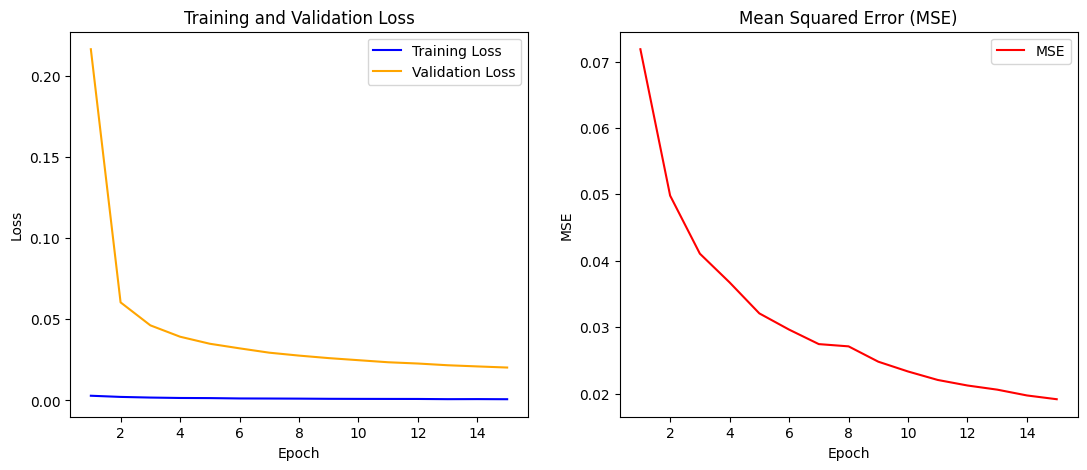

In [21]:
# Asegúrate de que el autoencoder esté en la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder().to(device)

# Definir el criterio (pérdida) y el optimizador
criterion = nn.MSELoss()  # Usamos el error cuadrático medio como pérdida
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)  # Optimizer Adam

# Entrenar el autoencoder completo (encoder + decoder)
train_loss, val_loss, mse_history = train_autoencoder(autoencoder, train_loader, criterion, optimizer, device=device)
show_curves(train_loss, val_loss, mse_history)

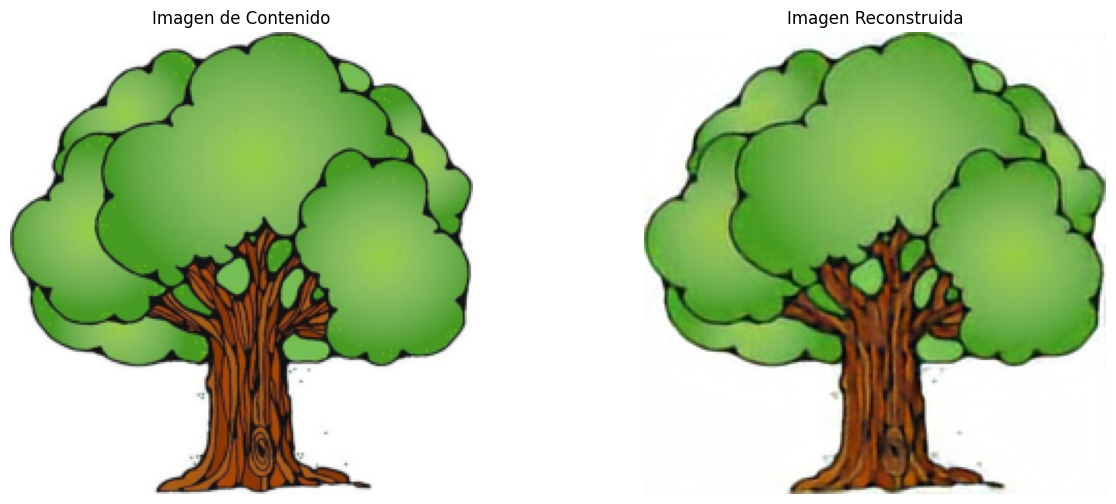

In [22]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Función para cargar y preprocesar la imagen
def load_image(image_path, size=(224, 224)):
    image = Image.open(image_path).convert('RGB')  # Abrir la imagen
    transform = transforms.Compose([
        transforms.Resize(size),  # Redimensionar la imagen
        transforms.ToTensor(),     # Convertir a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
    ])
    return transform(image).unsqueeze(0).cuda()  # Añadir dimensión de lote y mover a GPU

# Función para deshacer la normalización
def denormalize(tensor):
    # Desnormalizar la imagen
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).cuda()
    tensor = tensor * std + mean  # Inversa de la normalización
    tensor = torch.clamp(tensor, 0, 1)  # Asegurarse de que los valores estén entre 0 y 1
    return tensor

# Cargar imágenes de contenido y estilo
content_image_path = '/content/arbol.jpg'  # Cambia esta ruta
style_image_path = '/content/gato.jpg'      # Cambia esta ruta

content_image = load_image(content_image_path)
style_image = denormalize(load_image(style_image_path))

content_desnormalize= denormalize(content_image)
style_desnormalize= denormalize(style_image)

# Pasar la imagen de contenido a través del autoencoder (encoder + decoder)
with torch.no_grad():
    reconstructed_image = autoencoder(content_image)

# Deshacer la normalización en la imagen reconstruida
reconstructed_image = denormalize(reconstructed_image)

# Pasar la imagen reconstruida a la CPU y convertirla a numpy
reconstructed_image = reconstructed_image.cpu().detach().numpy().squeeze(0)

# Visualizar las imágenes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Mostrar imagen de contenido
axes[0].imshow(content_desnormalize.cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[0].set_title("Imagen de Contenido")
axes[0].axis("off")

# Mostrar imagen reconstruida
axes[1].imshow(reconstructed_image.transpose(1, 2, 0))
axes[1].set_title("Imagen Reconstruida")
axes[1].axis("off")
plt.savefig('resultado_reconstruccion.png')
plt.show()




